<a href="https://colab.research.google.com/github/shadinn/LDA-Indomaret/blob/main/%5BNLP%5D_LDA_Indomaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ide Project & Problem Scope

Mencari keyword yang bermakna dan memiliki asosiasi terhadap isu yang ada dapat dilakukan dengan metode NLP. Ide project ini adalah membagi kelompok review menjadi beberapa topik utama dari aplikasi KlikIndomaret dalam periode tertentu untuk mengklasifikasikan kecondongan suatu keyword (kata) yang dapat menggambarkan sebuah review sehingga sesuai dengan kelompok topik utamanya yang belum tertangkap dari nilai rating saja. Dengan metode yang dipakai adalah unsupervised machine learning LDA (Latent Dirichlet Allocation).


In [ ]:
pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from wordcloud import WordCloud

import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import spacy

%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data understanding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/belajar/NLP/dataset/dataset_klikindomaret.csv')
dataset.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,0,7d495b14-0038-4ee3-ab51-f0a436b6efd7,Abdullah Arif,https://play-lh.googleusercontent.com/a-/AD_cM...,Memudahkan beli galon. Hehe,5,0,2308200,2023-08-22 13:12:52,NaN,NaN,2308200
1,1,12ecd71e-2edf-473d-bb98-72ae44d4e328,Florinda Eka Prasada Waleulu,https://play-lh.googleusercontent.com/a-/AD_cM...,"Pesanan sesuai, di antar sampai ke rumah. Reco...",5,0,2308200,2023-08-22 12:11:29,NaN,NaN,2308200
2,2,aecac6b5-8f71-4f86-9682-eebafaec6d77,Heni Yati,https://play-lh.googleusercontent.com/a-/AD_cM...,Selalu komplit dan safety packingnya.,5,0,2308200,2023-08-22 11:04:19,NaN,NaN,2308200
3,3,d578e87c-a4f6-4bcc-a641-aaf94007277e,rahdek putra,https://play-lh.googleusercontent.com/a/AAcHTt...,Sangat bagus dan membantu,5,0,2308200,2023-08-22 08:37:40,NaN,NaN,2308200
4,4,03793074-879c-4db1-a0a6-8cf3ed191e1e,Marcus Beko,https://play-lh.googleusercontent.com/a/AAcHTt...,Suka sih cepet banget,5,0,NaN,2023-08-22 07:10:55,NaN,NaN,NaN


In [ ]:
dataset.dtypes


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0               int64
reviewId                object
userName                object
userImage               object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
replyContent            object
repliedAt               object
appVersion              object
dtype: object

In [ ]:
# Seleksi kolom
dataset = dataset.loc[:,('reviewId','userName', 'content','score', 'reviewCreatedVersion','at')]
dataset.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewId,userName,content,score,reviewCreatedVersion,at
0,7d495b14-0038-4ee3-ab51-f0a436b6efd7,Abdullah Arif,Memudahkan beli galon. Hehe,5,2308200,2023-08-22 13:12:52
1,12ecd71e-2edf-473d-bb98-72ae44d4e328,Florinda Eka Prasada Waleulu,"Pesanan sesuai, di antar sampai ke rumah. Reco...",5,2308200,2023-08-22 12:11:29
2,aecac6b5-8f71-4f86-9682-eebafaec6d77,Heni Yati,Selalu komplit dan safety packingnya.,5,2308200,2023-08-22 11:04:19
3,d578e87c-a4f6-4bcc-a641-aaf94007277e,rahdek putra,Sangat bagus dan membantu,5,2308200,2023-08-22 08:37:40
4,03793074-879c-4db1-a0a6-8cf3ed191e1e,Marcus Beko,Suka sih cepet banget,5,NaN,2023-08-22 07:10:55


In [ ]:
#ubah kolom at menjadi tipe data date time
dataset['at'] = pd.to_datetime(dataset['at'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# buat kolom baru bertipe datetime tahun
dataset['Tahun'] = dataset['at'].dt.year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewId,userName,content,score,reviewCreatedVersion,at,Tahun
0,7d495b14-0038-4ee3-ab51-f0a436b6efd7,Abdullah Arif,Memudahkan beli galon. Hehe,5,2308200,2023-08-22 13:12:52,2023
1,12ecd71e-2edf-473d-bb98-72ae44d4e328,Florinda Eka Prasada Waleulu,"Pesanan sesuai, di antar sampai ke rumah. Reco...",5,2308200,2023-08-22 12:11:29,2023
2,aecac6b5-8f71-4f86-9682-eebafaec6d77,Heni Yati,Selalu komplit dan safety packingnya.,5,2308200,2023-08-22 11:04:19,2023
3,d578e87c-a4f6-4bcc-a641-aaf94007277e,rahdek putra,Sangat bagus dan membantu,5,2308200,2023-08-22 08:37:40,2023
4,03793074-879c-4db1-a0a6-8cf3ed191e1e,Marcus Beko,Suka sih cepet banget,5,NaN,2023-08-22 07:10:55,2023


Frekuensi Review

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


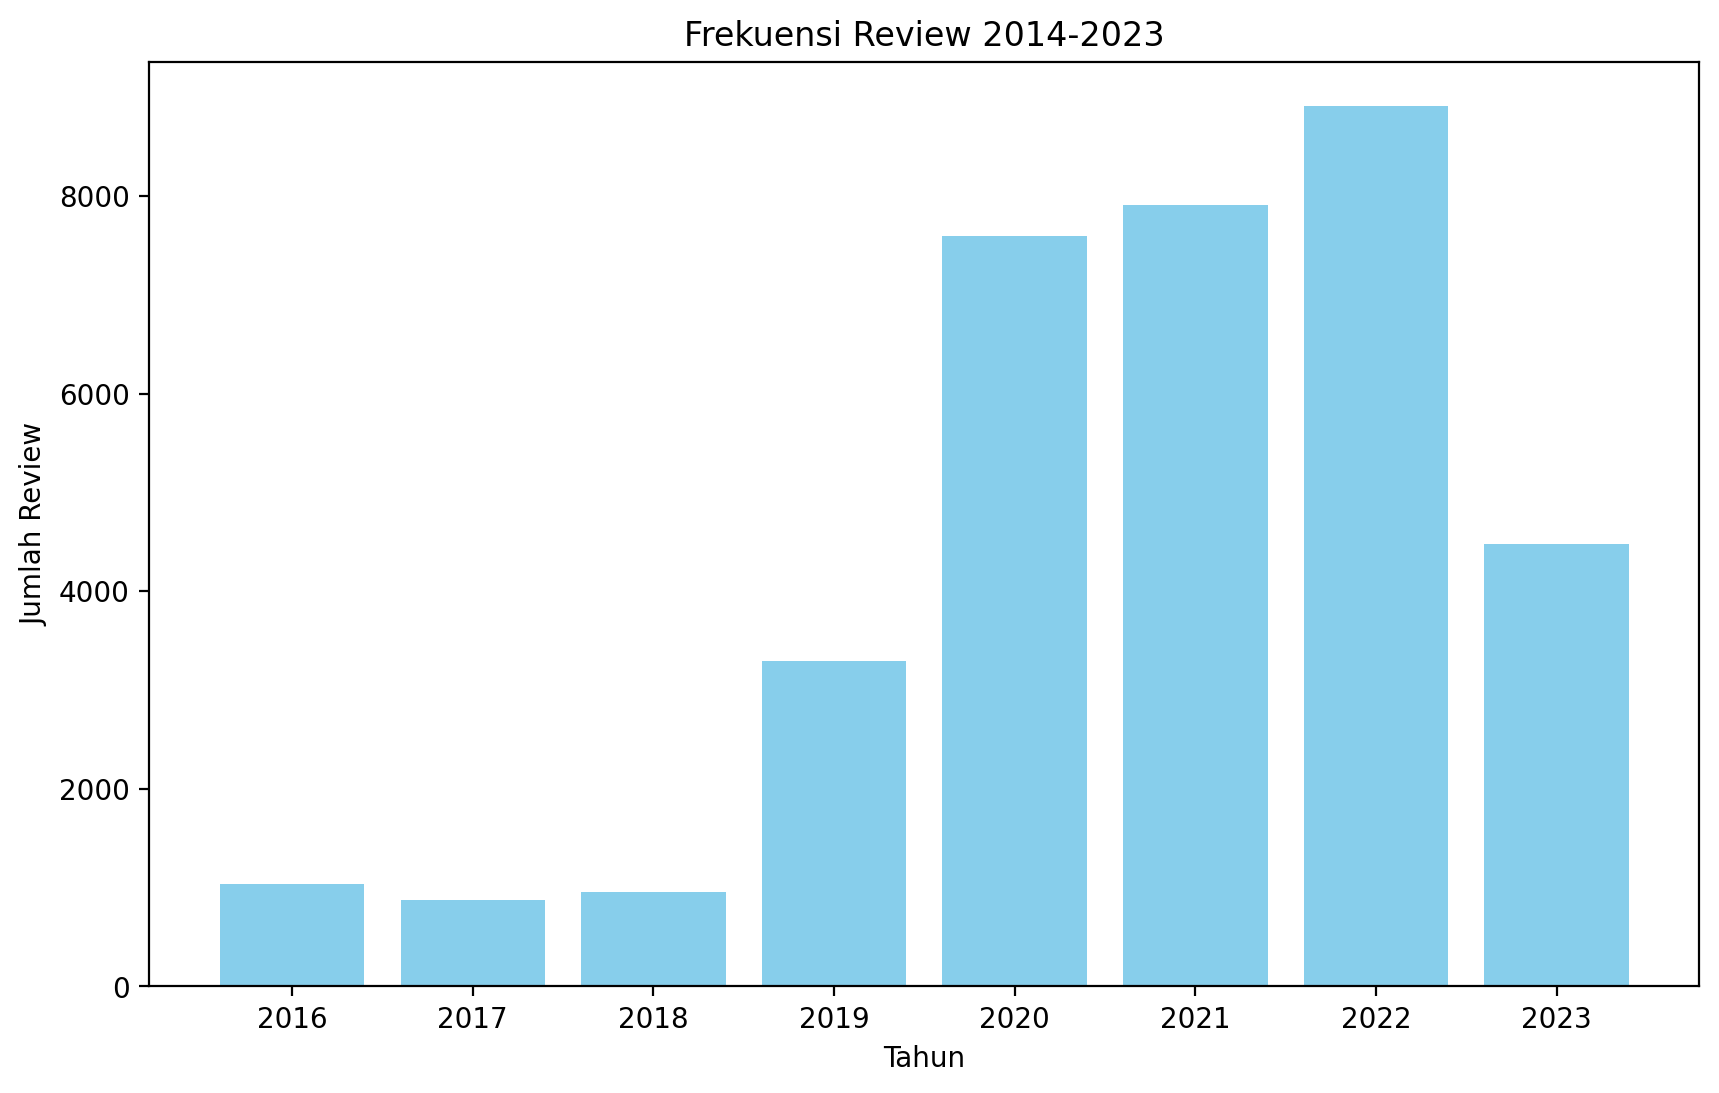

In [ ]:
review_counts = dataset['Tahun'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.bar(review_counts.index, review_counts.values, color='skyblue')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Review')
plt.title('Frekuensi Review 2014-2023')
plt.xticks(review_counts.index)
plt.show()

In [ ]:
# filter data tahun 2016 - 2023
filter_data = dataset[(dataset['Tahun'] >= 2016) & (dataset['Tahun'] <= 2023)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Hitung distribusi rating
rating_counts = filter_data['score'].value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


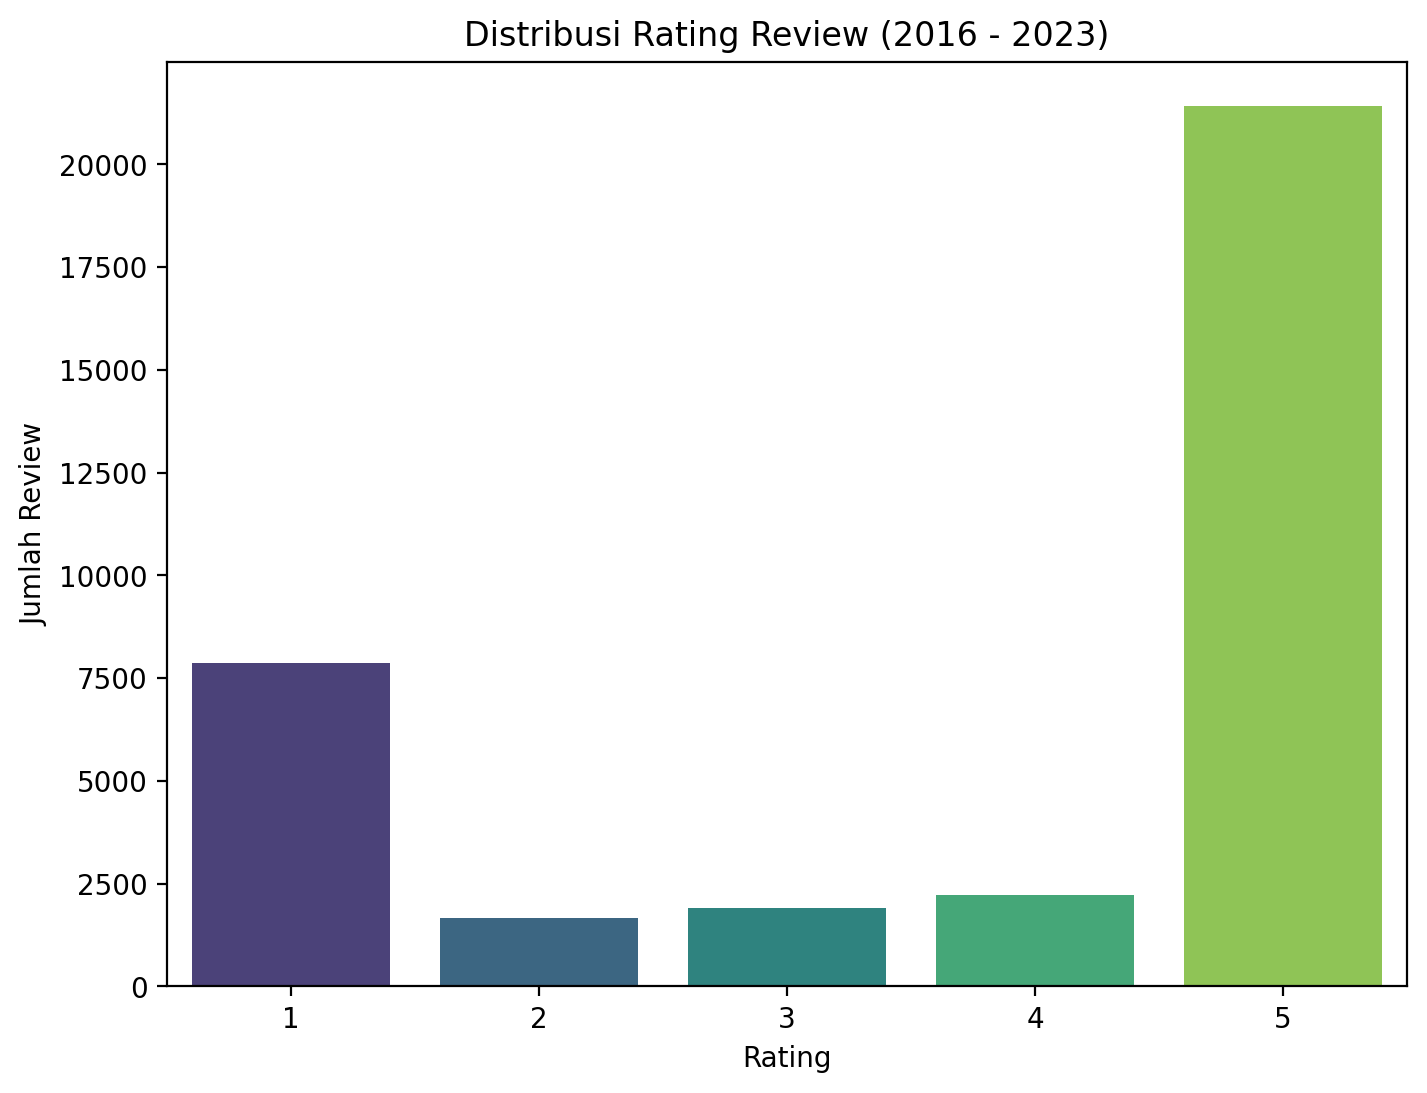

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.title('Distribusi Rating Review (2016 - 2023)')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


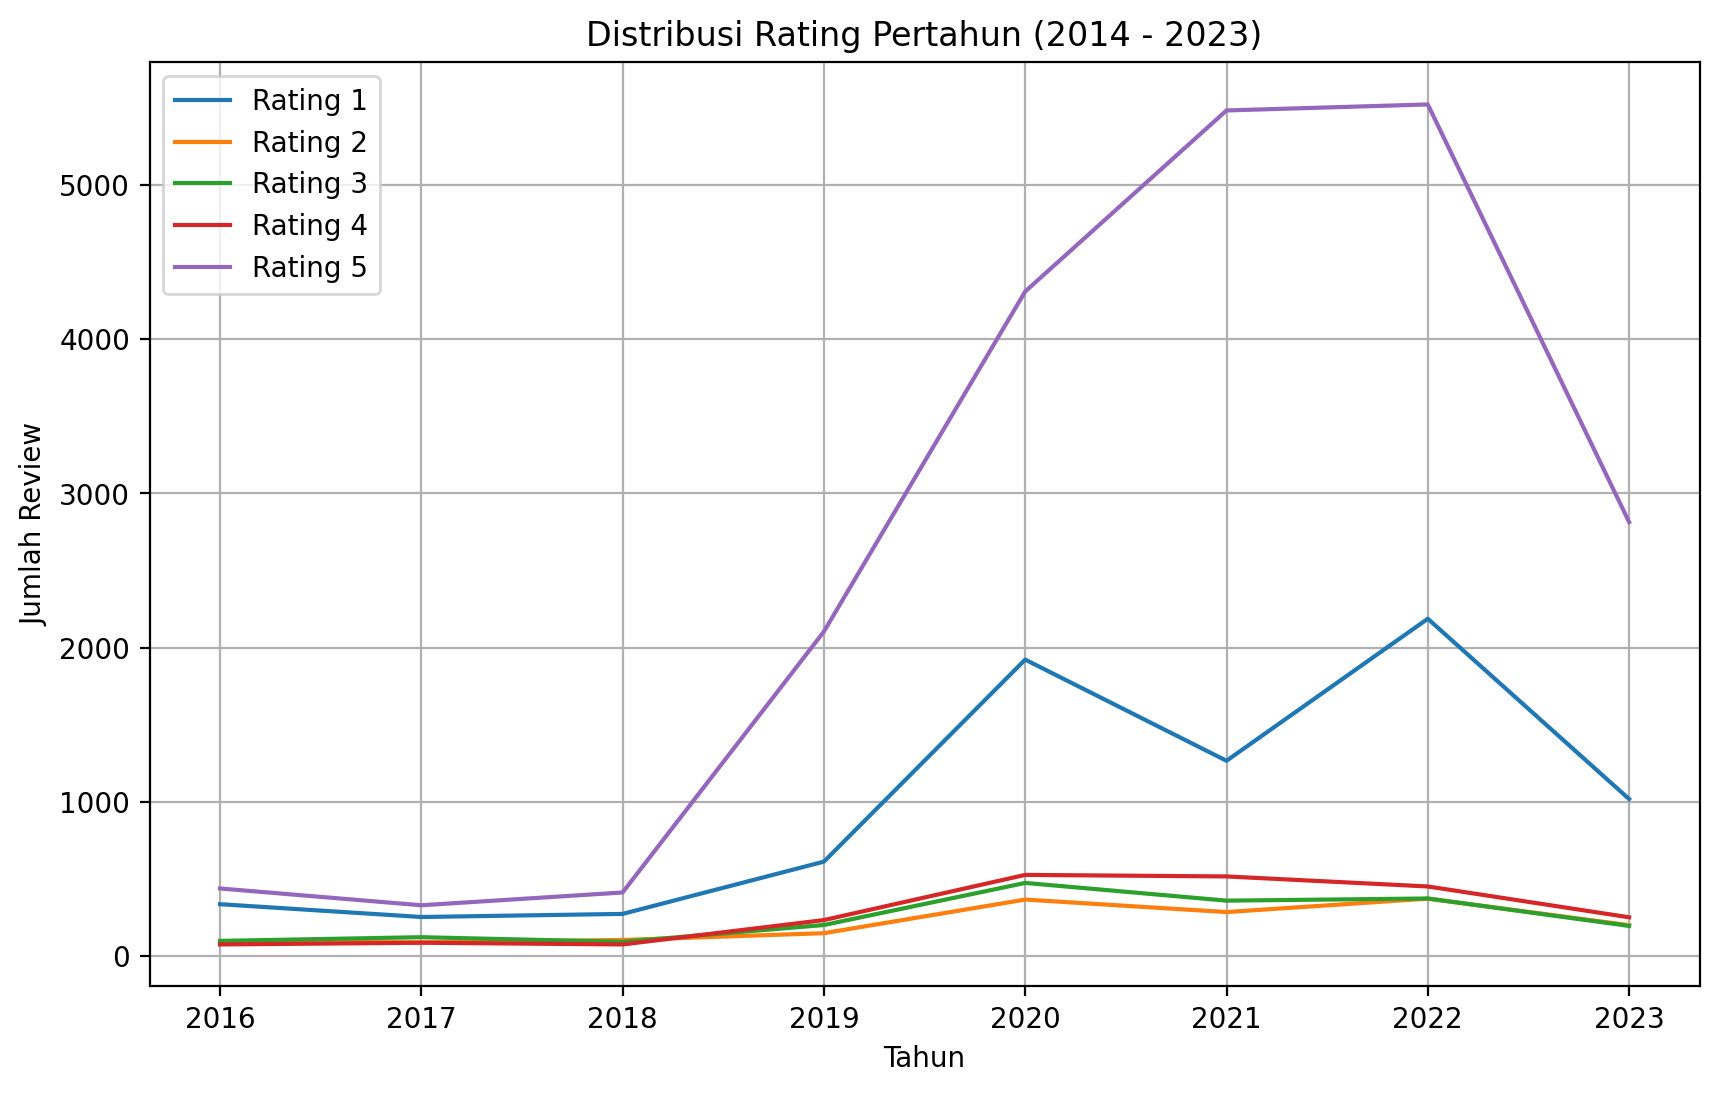

In [ ]:
# Hitung distribusi rating pertahun
rating_yearly = dataset.groupby(['Tahun', 'score']).size().unstack(fill_value=0)

# Membuat visualisasi menggunakan Line Chart (Matplotlib)
plt.figure(figsize=(10, 6))
for rating in range(1, 6):
    plt.plot(rating_yearly.index, rating_yearly[rating], label=f'Rating {rating}')

plt.xlabel('Tahun')
plt.ylabel('Jumlah Review')
plt.title('Distribusi Rating Pertahun (2014 - 2023)')
plt.legend()
plt.grid(True)
plt.show()

**insight**


*   Rating 5 selalu menjadi rating yang memiliki frekuensi tinggi jika dibanding dengan rating 1,2,3, dan 4 setiap periode tahunnya
*   Rating 5 sebagai frekuensi tertinggi terjadi di periode tahun 2021 - 2022. Sesuai kepada plot sebelumnya dimana jumlah review masuk tertinggi terjadi pada tahun 2021 - 2022, dan nilai rating 5 merupakan frekuensi tertinggi tahun 2021-2022, hal ini mununjukkan bahwa pada tahun 2021 - 2022 pengguna aplikasi memiliki nilai kepuasan yang tinggi dibanding tahun-tahun lainnya.




# Data Preparation

Data yang dipakai hanya data tahun 2023 agar data yang dipakai merupakan review terbaru

Data review 2023

In [ ]:
data = dataset[dataset['Tahun'] == 2023]
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewId,userName,content,score,reviewCreatedVersion,at,Tahun
0,7d495b14-0038-4ee3-ab51-f0a436b6efd7,Abdullah Arif,Memudahkan beli galon. Hehe,5,2308200,2023-08-22 13:12:52,2023
1,12ecd71e-2edf-473d-bb98-72ae44d4e328,Florinda Eka Prasada Waleulu,"Pesanan sesuai, di antar sampai ke rumah. Reco...",5,2308200,2023-08-22 12:11:29,2023
2,aecac6b5-8f71-4f86-9682-eebafaec6d77,Heni Yati,Selalu komplit dan safety packingnya.,5,2308200,2023-08-22 11:04:19,2023
3,d578e87c-a4f6-4bcc-a641-aaf94007277e,rahdek putra,Sangat bagus dan membantu,5,2308200,2023-08-22 08:37:40,2023
4,03793074-879c-4db1-a0a6-8cf3ed191e1e,Marcus Beko,Suka sih cepet banget,5,NaN,2023-08-22 07:10:55,2023


In [ ]:
data['score'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


score
5    2814
1    1018
4     251
2     200
3     195
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


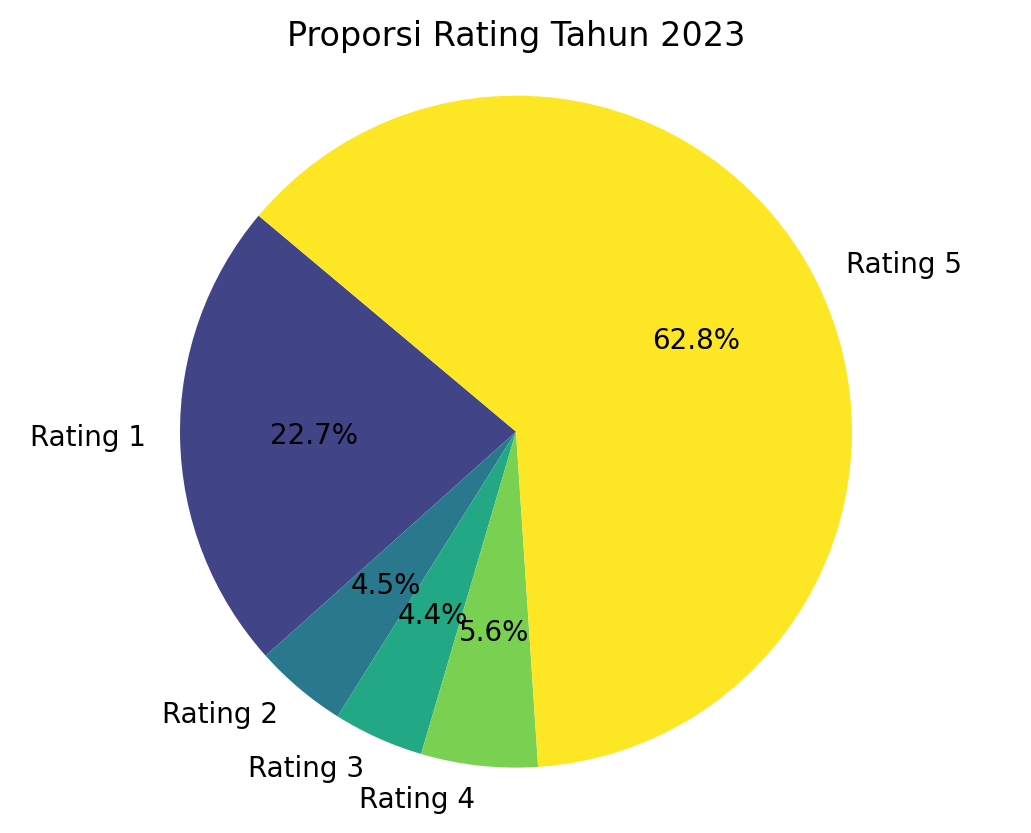

In [ ]:
# Hitung proporsi masing-masing rating
total_reviews = len(data)
rating_counts = data['score'].value_counts().sort_index()
proporsi_rating = rating_counts / total_reviews * 100

# Membuat visualisasi menggunakan Pie Chart (Matplotlib)
labels = [f'Rating {rating}' for rating in proporsi_rating.index]
plt.pie(proporsi_rating, labels=labels, autopct='%.1f%%', startangle=140, colors=plt.cm.viridis(proporsi_rating.index / 5))
plt.axis('equal')  # Membuat lingkaran berbentuk bulat
plt.title('Proporsi Rating Tahun 2023')
plt.show()

**Interpretasi**
Sesuai dengan informasi proporsi kelas pada data tahun 2023, terlihat porporsi yang timpang diantara ke lima kelas score. Terlihat jelas bahwa 62% dari customer yang memberikan review-rating puas terhadap performa aplikasi dan 22% memberikan review-rating tidak puas. Untuk meningkatkan pelayanan aplikasi, Indomaret perlu untuk segera mengetahui dan melakukan perbaikan kepada poin-poin yang memengaruhi nilai rating agar tidak kehilangan pengguna aplikasi.

Maka dari itu kita akan mencari isu/poin apa yang menjadi kendala atau yang terjadi di tahun 2023 agar harapannya dapat dilakukan perbaikan di tahun berikutnya yang sesuai dengan permasalahan terkini. Untuk menjawab permasalahan ini, kita akan memulai untuk membuat topic modeling dengan preprocessing text cleansing.


In [ ]:
data = data[data['score'].isin([1,2])]
data.index = range(len(data))
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewId,userName,content,score,reviewCreatedVersion,at,Tahun
0,bd07f449-c7bf-481f-bad1-a4aff06a2e16,Dimas Fahrezi,Aplikasi bosok sering gangguan.!!,1,2308200,2023-08-22 02:05:20,2023
1,e4302197-c841-4aee-afb8-169e20ebba31,Achmad Ansyari,"Udh pesen dan bayar, tapi pesanan tidak dikiri...",1,2308200,2023-08-21 14:31:02,2023
2,d06d70ad-f5cd-4719-8e5f-982a76fd0c79,Evani T. Ramadhanty,"Yaallah tiap mau buka apps ini kesel gue, past...",1,2308300,2023-08-21 09:35:20,2023
3,4f269f55-c19f-4da3-98c8-31a3029e1eca,Rosyid Asrori,Akun saya bisa diakses orang lain Aplikasi ini...,1,2308200,2023-08-21 07:18:38,2023
4,aab6ae11-7704-4b6a-83ef-d2af2da28463,Febri Febri,"Aplikasi gajelas, makin hari makin gajelas",1,2308300,2023-08-21 02:03:38,2023


In [ ]:
len(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1218

Text Cleansing

In [ ]:
data['review'] = data['content'].str.lower()


print('Case Folding Result : \n')
print(data['content'].head(5))
print('\n\n\n')

Case Folding Result : 

0                    Aplikasi bosok sering gangguan.!!
1    Udh pesen dan bayar, tapi pesanan tidak dikiri...
2    Yaallah tiap mau buka apps ini kesel gue, past...
3    Akun saya bisa diakses orang lain Aplikasi ini...
4           Aplikasi gajelas, makin hari makin gajelas
Name: content, dtype: object






/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-64-e534d71d3dfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['content'].str.lower()


Tokenizing

In [ ]:
import nltk
nltk.download('punkt')

import string
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# ------ Tokenizing ---------

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

data['review'] = data['review'].astype(str)
data['review'] = data['review'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

data['review'] = data['review'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data['review'] = data['review'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

data['review'] = data['review'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

data['review'] = data['review'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

data['review'] = data['review'].apply(remove_singl_char)

# NLTK word rokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['review_tokens'] = data['review'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n')
print(data['review_tokens'].head())
print('\n\n\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:19: DeprecationWarning: invalid escape sequence '\w'
<>:46: DeprecationWarning: invalid escape sequence '\s'
<>:19: DeprecationWarning: invalid escape sequence '\w'
<>:46: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-65-915f019cfc21>:19: DeprecationWarning: invalid escape sequence '\w'
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
<ipython-input-65-915f019cfc21>:46: DeprecationWarning: invalid escape sequence '\s'
  return re.sub('\s+',' ',text)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing Result : 

0                  [aplikasi, bosok, sering, gangguan]
1    [udh, pesen, dan, bayar, tapi, pesanan, tidak,...
2    [yaallah, tiap, mau, buka, apps, ini, kesel, g...
3    [akun, saya, bisa, diakses, orang, lain, aplik...
4     [aplikasi, gajelas, makin, hari, makin, gajelas]
Name: review_tokens, dtype: object






Stopwords

In [ ]:
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend([])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
txt_stopword = pd.read_csv("/content/drive/MyDrive/belajar/NLP/dataset/stopwords.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data['review_tokens_WSW'] = data['review_tokens'].apply(stopwords_removal)

print(data['review_tokens_WSW'].head())

0                          [aplikasi, bosok, gangguan]
1    [pesen, bayar, pesanan, dikirim, sampe, jam, p...
2    [yaallah, buka, apps, kesel, pastii, disuruh, ...
3                      [akun, diakses, aplikasi, aman]
4                         [aplikasi, gajelas, gajelas]
Name: review_tokens_WSW, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


normalization


In [ ]:
normalizad_word = pd.read_excel("/content/drive/MyDrive/belajar/NLP/dataset/normalisasi.xlsx")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

data['review_normalized'] = data['review_tokens_WSW'].apply(normalized_term)

data['review_normalized'].head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                          [aplikasi, busuk, gangguan]
1    [pesan, bayar, pesanan, dikirim, sampai, jam, ...
2    [yaallah, buka, aplikasi, kesel, pastii, disur...
3                      [akun, diakses, aplikasi, aman]
4                         [aplikasi, gajelas, gajelas]
5     [pengiriman, lambat, berbeda, aplikasi, sebelah]
6                 [aplikasi, keseringan, update, make]
7    [cuman, pegawai, indomaret, spam, bintang, zam...
8    [belanja, keterangan, dibatasi, beras, beli, p...
9                                         [pengiriman]
Name: review_normalized, dtype: object

Stemmin

In [ ]:
pip install swifter

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install sastrawi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemme
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in data['review_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

data['review_tokens_stemmed'] = data['review_normalized'].swifter.apply(get_stemmed_term)
print(data['review_tokens_stemmed'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2587
------------------------
aplikasi : aplikasi
busuk : busuk
gangguan : ganggu
pesan : pesan
bayar : bayar
pesanan : pesan
dikirim : kirim
sampai : sampai
jam : jam
komplain : komplain
slow : slow
respon : respon
yaallah : yaallah
buka : buka
kesel : kesel
pastii : pasti
disuruh : suruh
kasing : kasing
rating : rating
akun : akun
diakses : akses
aman : aman
gajelas : gajelas
pengiriman : kirim
lambat : lambat
berbeda : beda
sebelah : belah
keseringan : sering
update : update
make : make
cuman : cuman
pegawai : pegawai
indomaret : indomaret
spam : spam
bintang : bintang
zaman : zaman
gratis : gratis
ongkir : ongkir
minimal : minimal
belanja : belanja
ayo : ayo
beralih : alih
alfagift : alfagift
keterangan : terang
dibatasi : batas
beras : beras
beli : beli
periode : periode
solusinya : solusi
jadul : jadul
rusak : rusak
pelayanan : layan
muncul : muncul
dibatalkan : batal
pembayaran : bayar
selesai : selesai
pergerakan : gera
aplikasinya : aplikasi
lama : lama
ampun : ampun
tolong : 

Pandas Apply:   0%|          | 0/1218 [00:00<?, ?it/s]

0                               [aplikasi, busuk, ganggu]
1       [pesan, bayar, pesan, kirim, sampai, jam, pesa...
2       [yaallah, buka, aplikasi, kesel, pasti, suruh,...
3                           [akun, akses, aplikasi, aman]
4                            [aplikasi, gajelas, gajelas]
                              ...                        
1213                         [masukin, barang, keranjang]
1214    [ud, dimasukin, keranjang, keranjang, kosong, ...
1215                                           [aplikasi]
1216    [aplikasi, lama, tambah, barang, keranjang, la...
1217                         [kecewa, paket, data, bayar]
Name: review_tokens_stemmed, Length: 1218, dtype: object


In [ ]:
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(['lemooootttt','wkkk','klik','indomaret','bgttttt','msuk','ampass','plisss','stlh','infomaret','asweew','anjr','stengah','mamypokoasli','jelasdiketok','bayarsering','sayabeli',
                       'jancuk','php','gede','klikindomaret','usa',' kumplitklik','alfmat','gregetan','selau','alfa','alfamard','cpt','sabarini','woyyyy','lagihadehhh','cht','taik','kmnh','dhh','sekalisuka',
                       'lagimerugikan','suda','gampangharap','tersebutjika','seringkali','suda','matiminta','bgd','apus','pulajadilah','abisss','ituuukalo','manapdhl','kmehh','tagg','ctm','nyeni','bangetmau',
                       'mampuss','gaaa','tlp','hpus','jkt','sekaliribet','ajaklo','lngsung','burukkaryawannya','kosongharusnya','sendiriharusnya','membagongkannya','qty','bangwt','piatos','tholol','yaallah','kesel','jam',
                       'bisssaaaaaaa','aaaaahkkkk','gmna','pda','kemanain','sangatsangat','hadeuhhh','dehhh','masya','allah','selulu','sampa','sebel','printan','maaf','donkbiar','msih','trnyta','pling','gajelas','busuk',
                       'alfagift','tolong','belah','pilih','buka','isi','bbrp','indomaretnya','aplikasi','alfamart','alfamartsaya','alfamartbelajar','muluuuu','ckckckckckck','ad','kada','maksa','alfagif','bon','mending',
                       'pakai','muncul','makan','ngga','rbkalo','thn','msuk','brgnya','laingimana','teman','hrsnya','tololl','muluu','masukin'])

# ----------------------- add stopword from txt file ------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data['review_bersih'] = data['review_tokens_stemmed'].apply(stopwords_removal)

print(data['review_bersih'].head())

0                                             [ganggu]
1    [pesan, bayar, pesan, kirim, pesan, komplain, ...
2                              [suruh, kasing, rating]
3                                  [akun, akses, aman]
4                                                   []
Name: review_bersih, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Menghapus review yang kosong
doc_clean = data[data['review_bersih'].apply(lambda x: x != [])]
doc_clean = doc_clean.loc[:,('reviewId','userName', 'content','score', 'reviewCreatedVersion','at','review_bersih')]
doc_clean.index = range(len(doc_clean))
doc_clean

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,reviewId,userName,content,score,reviewCreatedVersion,at,review_bersih
0,bd07f449-c7bf-481f-bad1-a4aff06a2e16,Dimas Fahrezi,Aplikasi bosok sering gangguan.!!,1,2308200,2023-08-22 02:05:20,[ganggu]
1,e4302197-c841-4aee-afb8-169e20ebba31,Achmad Ansyari,"Udh pesen dan bayar, tapi pesanan tidak dikiri...",1,2308200,2023-08-21 14:31:02,"[pesan, bayar, pesan, kirim, pesan, komplain, ..."
2,d06d70ad-f5cd-4719-8e5f-982a76fd0c79,Evani T. Ramadhanty,"Yaallah tiap mau buka apps ini kesel gue, past...",1,2308300,2023-08-21 09:35:20,"[suruh, kasing, rating]"
3,4f269f55-c19f-4da3-98c8-31a3029e1eca,Rosyid Asrori,Akun saya bisa diakses orang lain Aplikasi ini...,1,2308200,2023-08-21 07:18:38,"[akun, akses, aman]"
4,d8efef06-4f45-48f4-a369-388941fd2b99,Himatul Indriyani,Pengiriman sangat lambat berbeda sekali dengan...,1,2308200,2023-08-21 02:00:16,"[kirim, lambat, beda]"
...,...,...,...,...,...,...,...
1158,68ed639b-8de1-4335-b9b5-afe7422630d5,harudin fajri,update terus makin bengak,1,2212101,2023-01-01 18:46:20,[bengak]
1159,85b5bd74-4873-4434-b21a-2b1ddbe8f276,Anikotul Atiah,Ga bisa masukin barang ke kranjang,1,2212300,2023-01-01 11:12:30,"[barang, keranjang]"
1160,cc556213-6b10-4f8a-a3fb-6e81013c2151,Dicky Fenesia,Ud dimasukin ke keranjang byk tapi pas dicej k...,1,2212300,2023-01-01 10:48:39,"[ud, dimasukin, keranjang, keranjang, kosong, ..."
1161,758516aa-3be4-4252-a3da-40da7c575916,DnC Studio,"Aplikasi nya lemot , tambahkan barang ke keran...",1,2212300,2023-01-01 03:12:37,"[barang, keranjang, proses, bayar, lancar, int..."


# Model

**Create Dictionary and Corpus**


> The two main inputs to the LDA topic model are the dictionary and the corpus:
1. Dictionary: The idea of the dictionary is to give each token a unique ID.
2. Corpus: Having assigned a unique ID to each token, the corpus simply contains each ID and its frequency (if you wanna dive into it, then search for Bag of Word (BoW) which will introduce you to word embedding).



In [ ]:
import gensim
from gensim import corpora

dictionary = corpora.Dictionary(doc_clean['review_bersih'])
print(dictionary)

corpus = [dictionary.doc2bow(doc) for doc in doc_clean['review_bersih']]

Dictionary<1877 unique tokens: ['ganggu', 'bayar', 'kirim', 'komplain', 'pesan']...>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Optimal Number of Topics**

> After having constructed the topics, a coherence score can be computed. The score measures the degree of semantic similarity between high scoring words in each topic. In this fashion, a coherence score can be computed for each iteration by inserting a varying number of topics.

> A range of algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). Working with the gensim library makes computing these coherence measures for topic models fairly simple. I personally choose to implement C_v and C_umass. The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). Values above 0.5 are fairly good, according to John McLevey (source: Doing Computational Social Science: A Practical Introduction By John McLevey). On the other hand, C_umass returns negative values.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


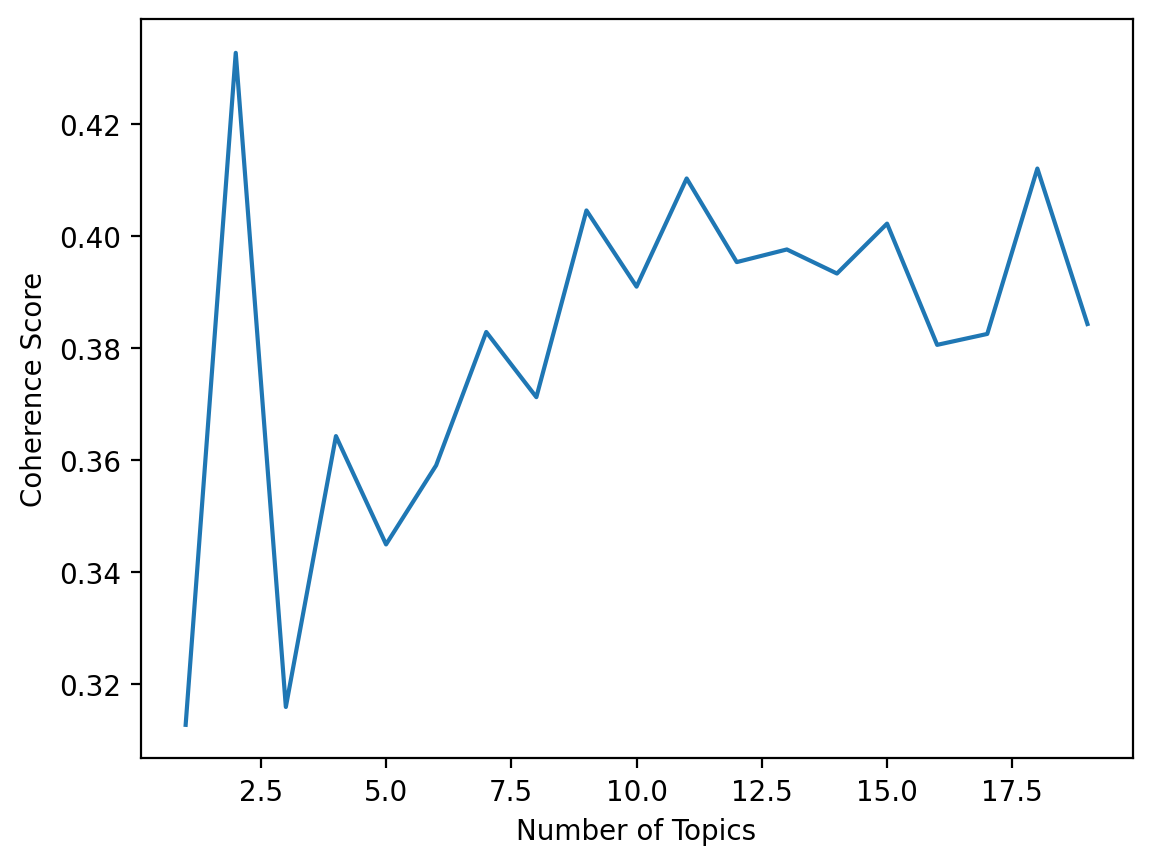

In [ ]:
#Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = doc_clean['review_bersih'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

**Build Model**
> When inserting our corpus into the topic modelling algorithm, the corpus gets analyzed in order to find the distribution of words in each topic and the distribution of topics in each document.
> As input, I give the model our corpus and dictionary from before; besides, I choose to iterate over the corpus 50 times to optimize the model parameters (this is the default value). I select the number of topics to be ten and the workers to be 4 (find the number of cores on your PC by pressing the ctr+shift+esc keys). The pass is 10, which means the model will pass through the corpus ten times during training.

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=10)
lda_model.print_topics(-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.052*"alamat" + 0.034*"daftar" + 0.021*"susah" + 0.013*"pesan" + 0.011*"beli" + 0.011*"bug" + 0.009*"kupon" + 0.008*"menu" + 0.008*"login" + 0.008*"verifikasi"'),
 (1,
  '0.041*"pesan" + 0.030*"belanja" + 0.030*"barang" + 0.020*"toko" + 0.020*"bayar" + 0.018*"keranjang" + 0.017*"batal" + 0.012*"kosong" + 0.011*"kirim" + 0.011*"kecewa"'),
 (2,
  '0.027*"toko" + 0.022*"barang" + 0.016*"kirim" + 0.013*"saldo" + 0.013*"order" + 0.011*"loading" + 0.011*"beli" + 0.010*"bayar" + 0.010*"belanja" + 0.010*"lambat"')]

In [ ]:
lda_model[corpus][0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.18667503), (1, 0.64613837), (2, 0.16718657)]

In [ ]:
doc_clean['content'][0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Aplikasi bosok sering gangguan.!!'

In [ ]:
# Word Count of Topic Keywords

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_imp_wcount = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
print(df_imp_wcount)

          word  topic_id  importance  word_count
0       alamat         0    0.051551           0
1       daftar         0    0.033897           0
2        susah         0    0.020515           0
3        pesan         0    0.012567           0
4         beli         0    0.011370           0
5          bug         0    0.011286           0
6        kupon         0    0.009263           0
7         menu         0    0.008463           0
8        login         0    0.008408           0
9   verifikasi         0    0.007946           0
10       pesan         1    0.041493           0
11     belanja         1    0.029895           0
12      barang         1    0.029839           0
13        toko         1    0.020264           0
14       bayar         1    0.019632           0
15   keranjang         1    0.017672           0
16       batal         1    0.016838           0
17      kosong         1    0.012430           0
18       kirim         1    0.010893           0
19      kecewa      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import files
df_imp_wcount.to_excel('dataset_indomaret_wcount.xlsx')
files.download('dataset_indomaret_wcount.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**visualisai**

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


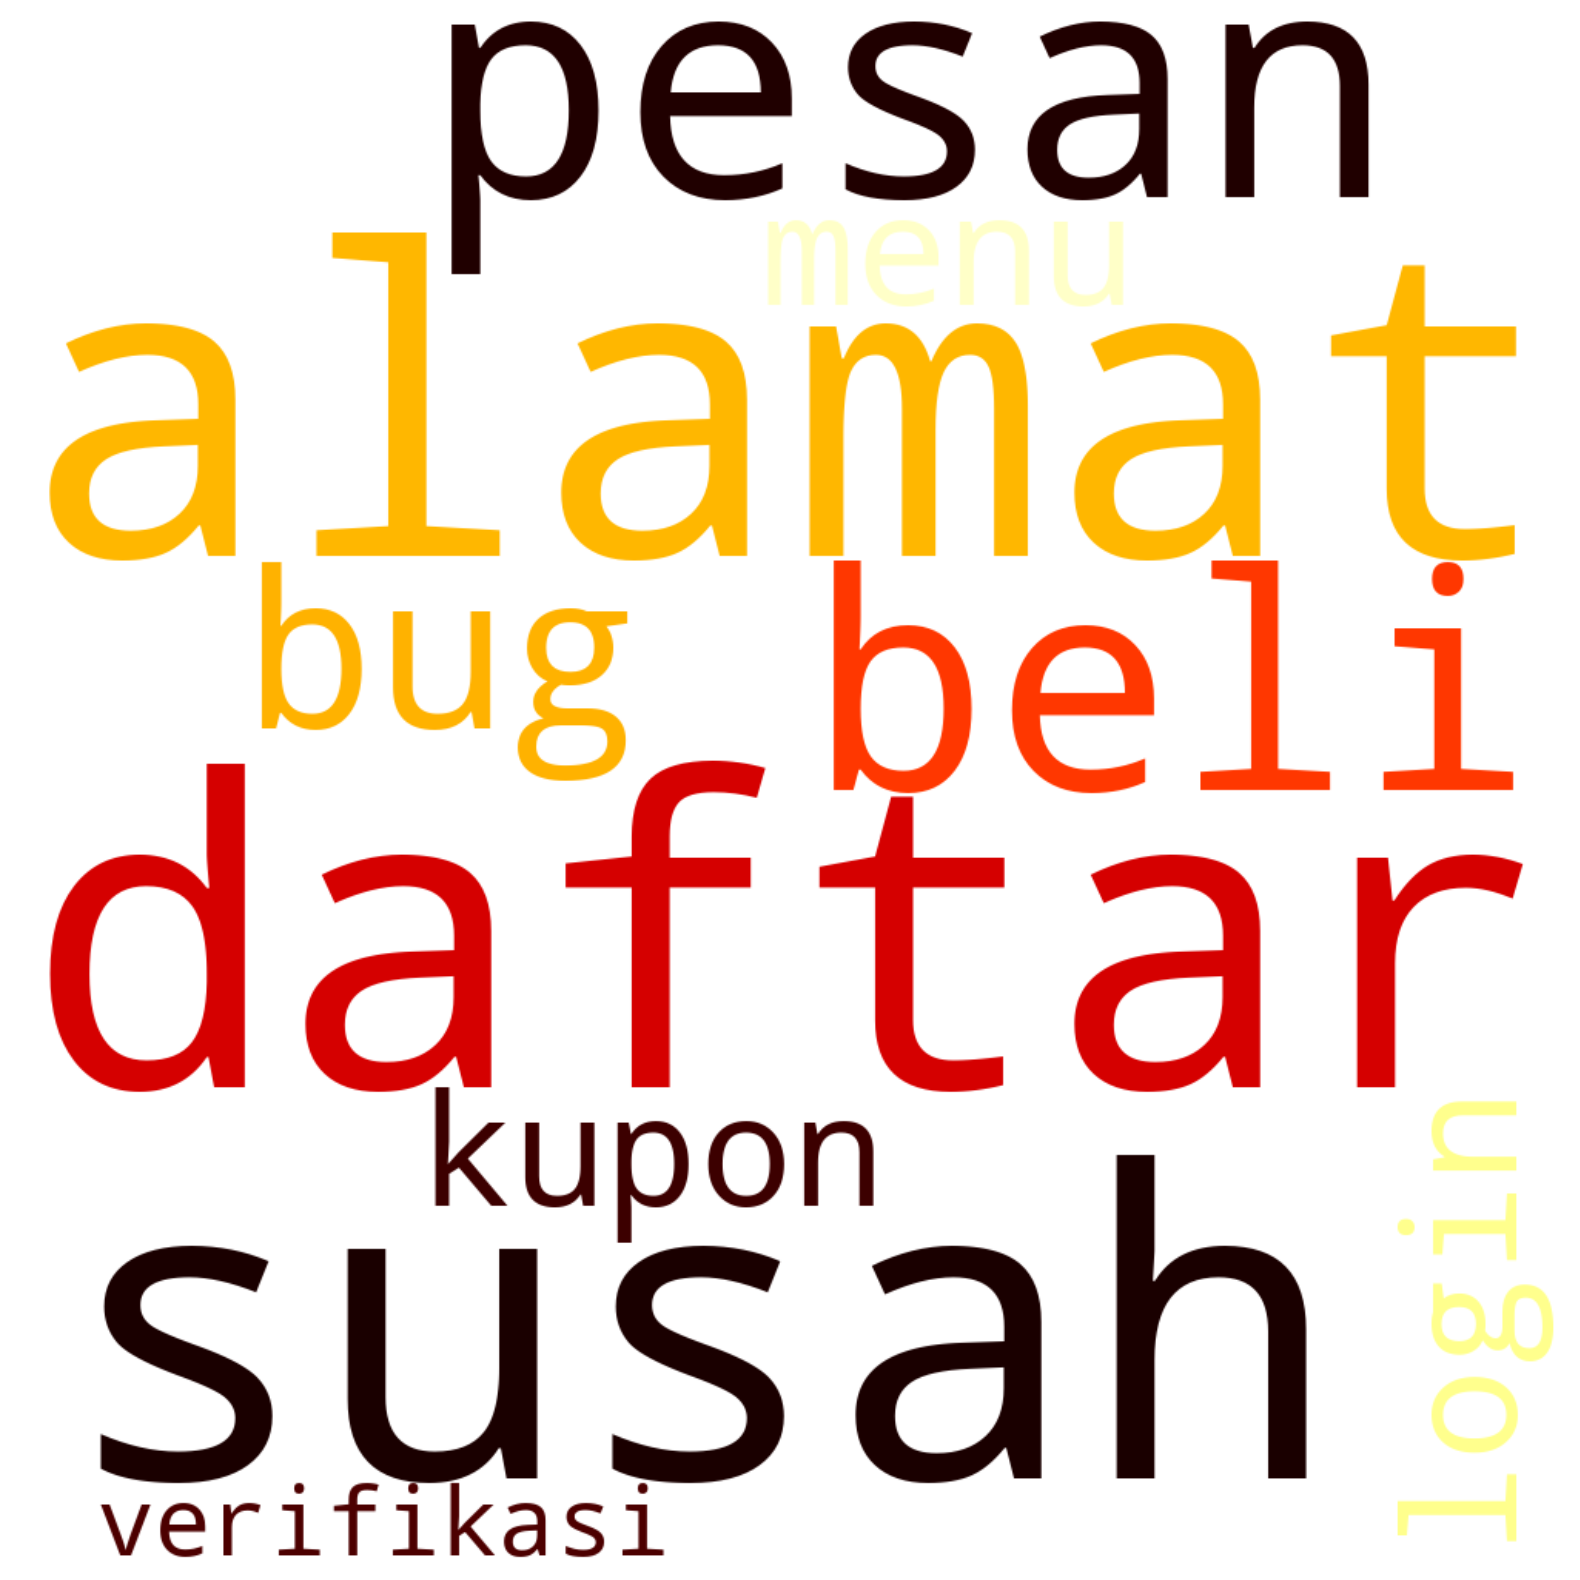

In [ ]:
#topic == 0
clean_s1 = df_imp_wcount[df_imp_wcount['topic_id'] == 0]
clean_text_s0 = ' '.join(word for word in clean_s1['word'])
wordcloud = WordCloud(colormap='hot_r', width=1000, height=1000, mode='RGBA', background_color='White').generate(clean_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


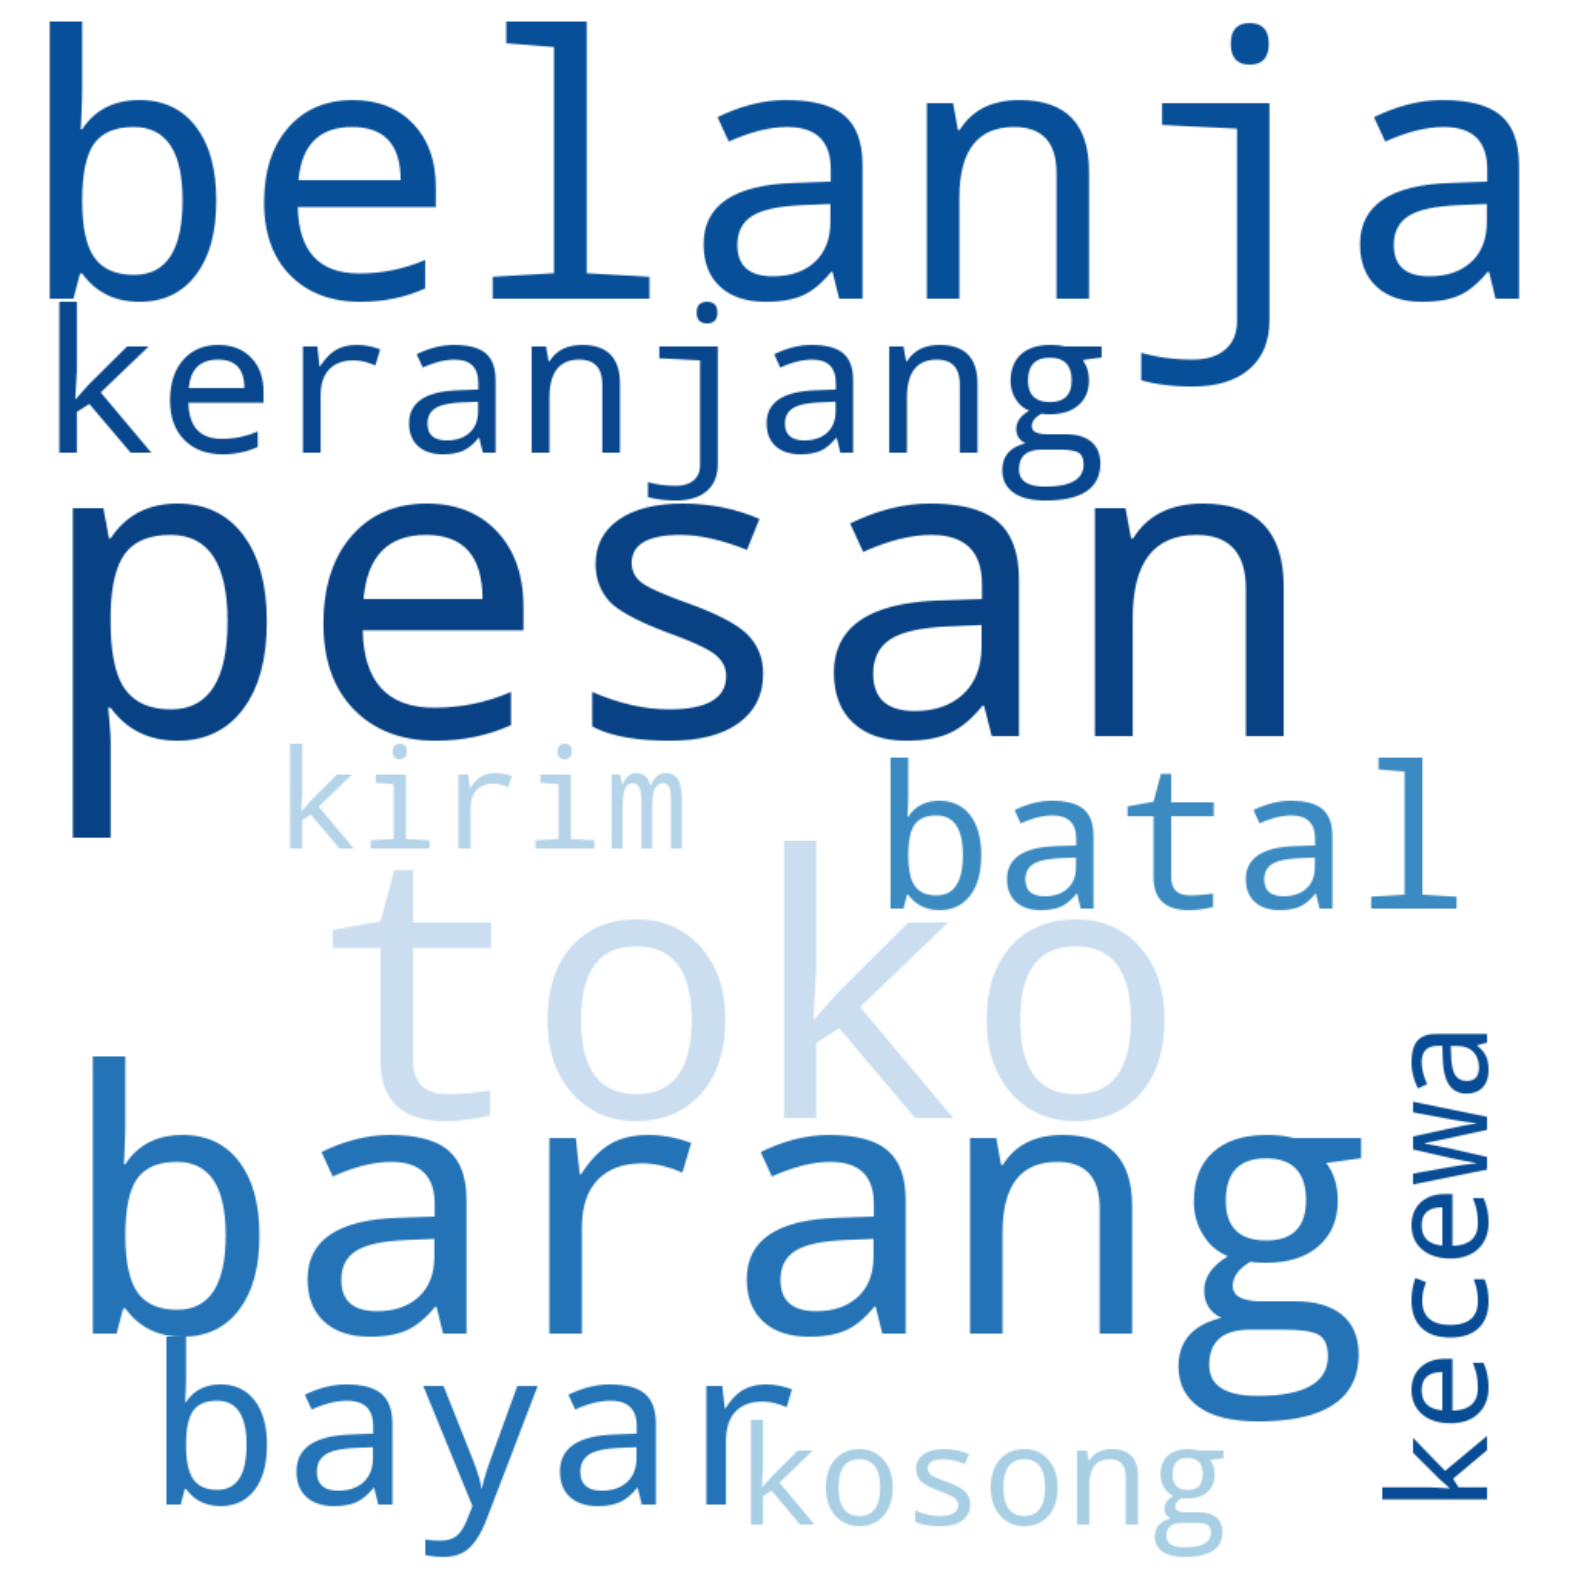

In [ ]:
#topic == 1
clean_s1 = df_imp_wcount[df_imp_wcount['topic_id'] == 1]
clean_text_s0 = ' '.join(word for word in clean_s1['word'])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='White').generate(clean_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


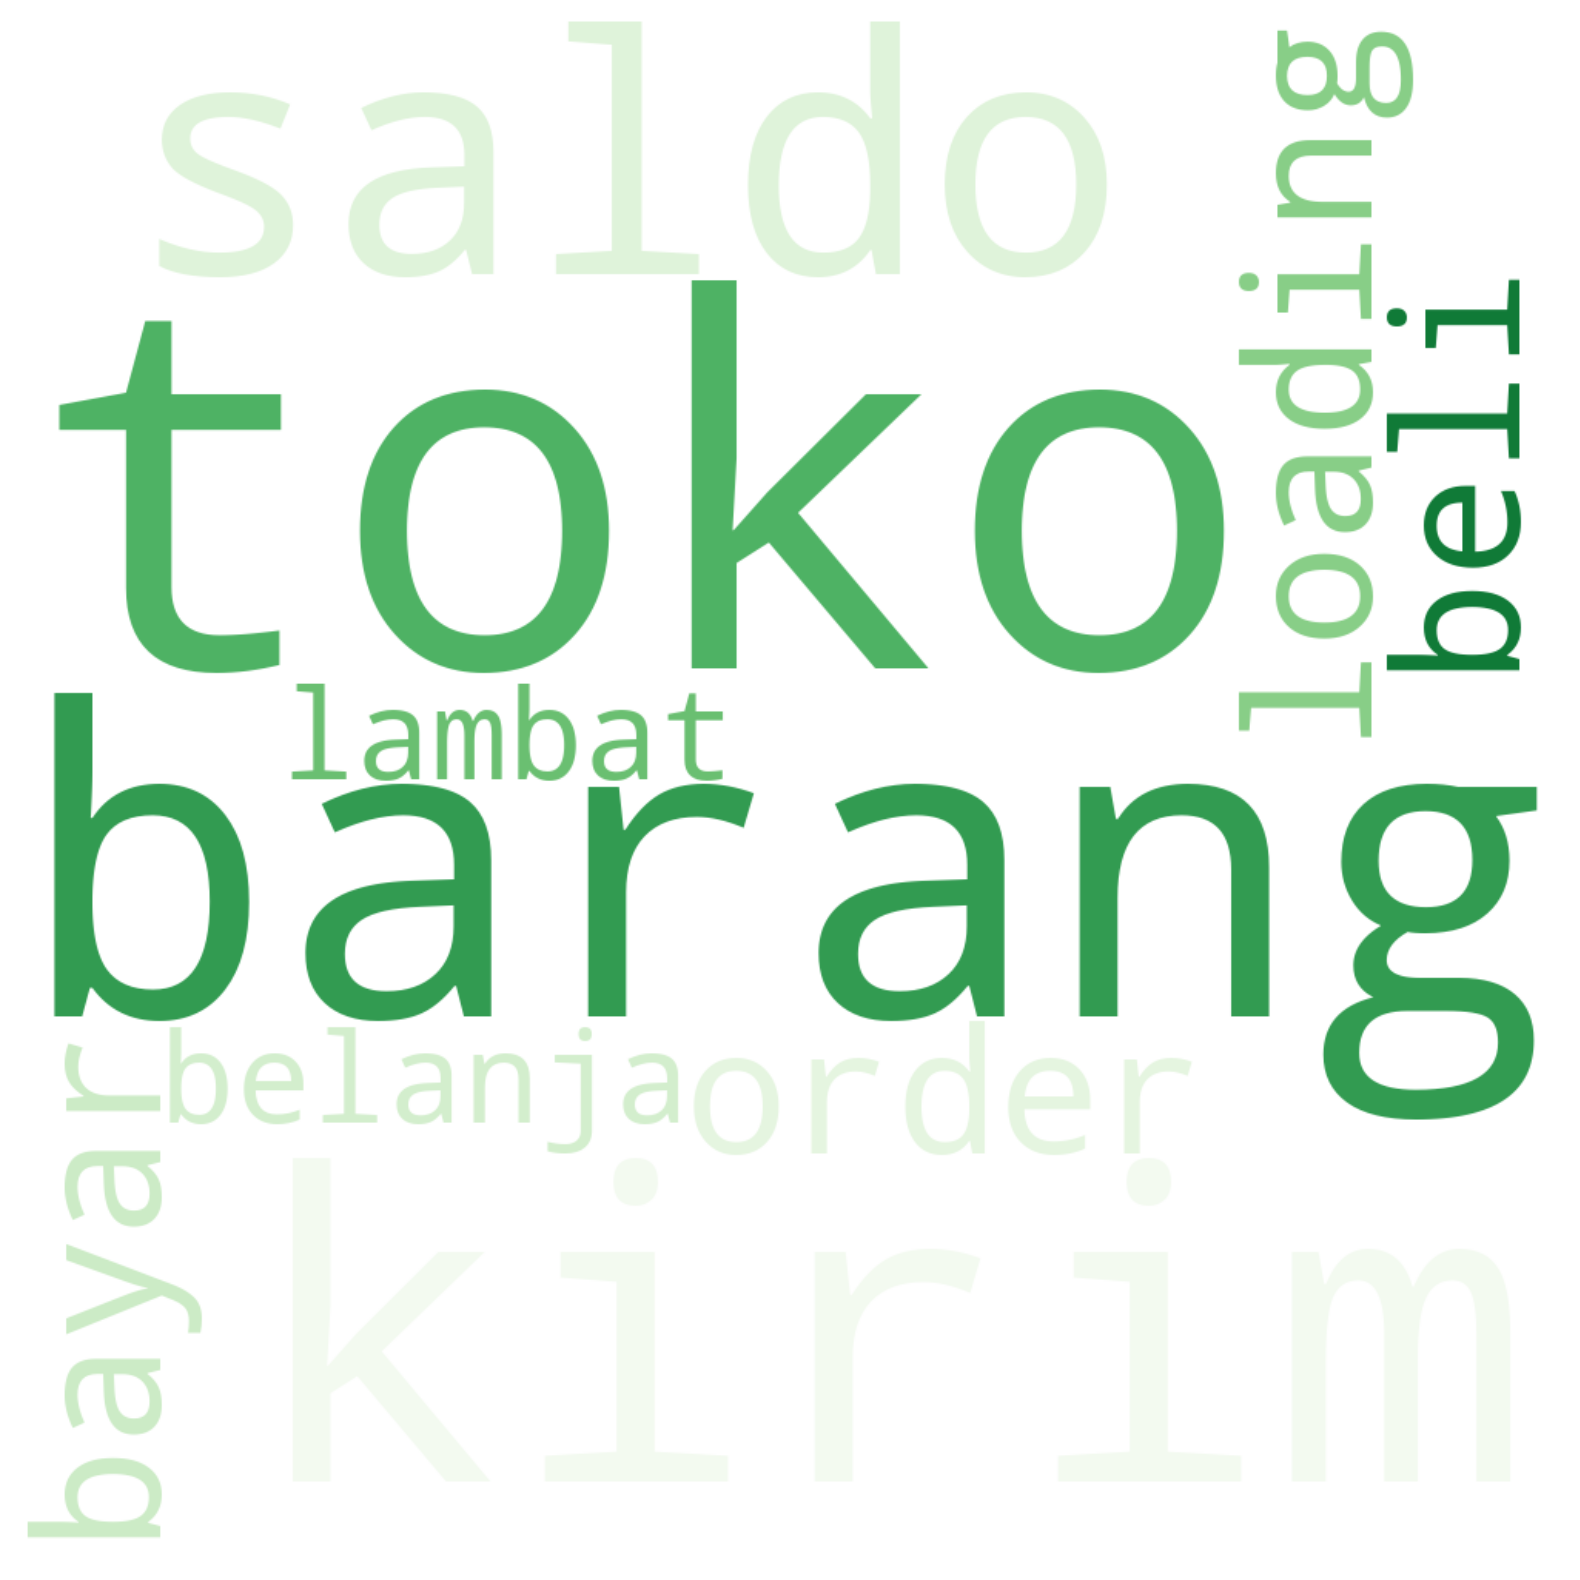

In [ ]:
#topic == 2
clean_s1 = df_imp_wcount[df_imp_wcount['topic_id'] == 2]
clean_text_s0 = ' '.join(word for word in clean_s1['word'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='White').generate(clean_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.show()

In [ ]:
#Dominant topic and its percentage contribution in each topic
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    data = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        dominant_topic = None
        perc_contribution = None
        topic_keywords = None
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                dominant_topic = int(topic_num)
                perc_contribution = round(prop_topic, 4)
            else:
                break

        # Add the information to the list
        data.append({'Dominant_Topic': dominant_topic, 'Perc_Contribution': perc_contribution, 'Topic_Keywords': topic_keywords, 'Text': texts[i]})

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)
    return df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_clean['content'])
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.6459,"pesan, belanja, barang, toko, bayar, keranjang...",Aplikasi bosok sering gangguan.!!
1,1,1,0.9189,"pesan, belanja, barang, toko, bayar, keranjang...","Udh pesen dan bayar, tapi pesanan tidak dikiri..."
2,2,0,0.5051,"alamat, daftar, susah, pesan, beli, bug, kupon...","Yaallah tiap mau buka apps ini kesel gue, past..."
3,3,1,0.8164,"pesan, belanja, barang, toko, bayar, keranjang...",Akun saya bisa diakses orang lain Aplikasi ini...
4,4,2,0.8241,"toko, barang, kirim, saldo, order, loading, be...",Pengiriman sangat lambat berbeda sekali dengan...
...,...,...,...,...,...
1158,1158,1,0.6627,"pesan, belanja, barang, toko, bayar, keranjang...",update terus makin bengak
1159,1159,1,0.7674,"pesan, belanja, barang, toko, bayar, keranjang...",Ga bisa masukin barang ke kranjang
1160,1160,1,0.9041,"pesan, belanja, barang, toko, bayar, keranjang...",Ud dimasukin ke keranjang byk tapi pas dicej k...
1161,1161,0,0.5257,"alamat, daftar, susah, pesan, beli, bug, kupon...","Aplikasi nya lemot , tambahkan barang ke keran..."


In [ ]:
from google.colab import files
df_dominant_topic.to_excel('dataset_topic.xlsx')
files.download('dataset_topic.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Interpretasi

**Topik 1 : Akses dan Otentikasi Pengguna**

1.   Sering terjadi masalah terutama jika berkaitan dengan proses pendaftaran, login, dan verifikasi pengguna.
2.   kesalahan dalam mengelola informasi pengguna seperti alamat.

**Topik 2 : Manajamen stock dan fungsionalitas keranjang belanja**
1. Ketersediaan barang yang salah atau tidak akurat dalam aplikasi.
2. Fitur keranjang belanja tidak berfungsi sebagaimana mestinya.

**Topik 3 : Proses Transaksi dan Layanan**
1. lambatnya proses pembayaran atau masalah dalam menyelesaikan transaksi keuangan.
2. kesalahan, gangguan, atau error saat mencoba untuk melakukan order atau pembelian di dalam aplikasi.
3. Keterlambatan dalam pengiriman produk atau layanan setelah melakukan transaksi.



